In [1]:
# The essentials
import numpy as np
import pandas as pd

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Std lib
from collections import defaultdict, Counter

from tqdm import tqdm_notebook

In [2]:
# load text and ciphertexts in pandas dataframe
train = pd.read_csv('../input/training.csv', index_col='index')
train['length'] = train['text'].apply(lambda x: len(x))
# ceil the length of the plain texts and save locally (for matching plain and cipher texts)
train['length_100'] = (np.ceil(train['length'] / 100) * 100).astype(int)
test = pd.read_csv('../input/test.csv')
test['length'] = test['ciphertext'].apply(lambda x: len(x))

# 0. Loading the prerequisites, based on the two previous kernels

In [3]:
# Difficulty 1
alphabet = """7lx4v!2oQ[O=,yCzV:}dFX#(Wak/bqne*JApK{cmf6 GZDj9gT\'"YSHiE]5)81hMNwI@P?Us%;30uBrLR-.$t"""
key =      """ etaoinsrhldcumfygwpb.v,kI\'T"A-SBMxDHj)CW(ELORN!FGPJz0qK?1VY:U92/3*5;478QZ6X%$}#@={[]"""

decrypt_mapping = {}
encrypt_mapping = {}
for i, j in zip(alphabet, key):
    decrypt_mapping[ord(i)] = ord(j)
    encrypt_mapping[ord(j)] = ord(i)

def encrypt_step1(x):
    return x.translate(encrypt_mapping)

def decrypt_step1(x):
    return x.translate(decrypt_mapping)

# Difficulty 2
def encrypt_step2(plaintext, key='xenophon', alphabet='aAbBcCdDeEfFgGhHiIjJkKlLmMnNoOpPqQrRsStTuUvVwWxXyYzZ'):
    key_length = len(key)
    cntr = 0
    ciphertext = ''
    for i, c in enumerate(plaintext):
        if c in alphabet:
            charIndex = alphabet.index(c)
            keyIndex = alphabet.index(key[cntr])
            newIndex = (charIndex + keyIndex) % len(alphabet)
            ciphertext += alphabet[newIndex]
            cntr = (cntr + 1) % key_length
        else:
            ciphertext += c
            
    return ciphertext

def decrypt_step2(ciphertext, key='xenophon', alphabet='aAbBcCdDeEfFgGhHiIjJkKlLmMnNoOpPqQrRsStTuUvVwWxXyYzZ'):
    key_length = len(key)
    cntr = 0
    plaintext = ''
    for i, c in enumerate(ciphertext):
        if c in alphabet:
            charIndex = alphabet.index(c)
            keyIndex = alphabet.index(key[cntr])
            newIndex = (charIndex - keyIndex) % len(alphabet)
            plaintext += alphabet[newIndex]
            cntr = (cntr + 1) % key_length
        else:
            plaintext += c
            
    return plaintext


# 1. Frequency analysis difficulty 2 vs difficulty 3

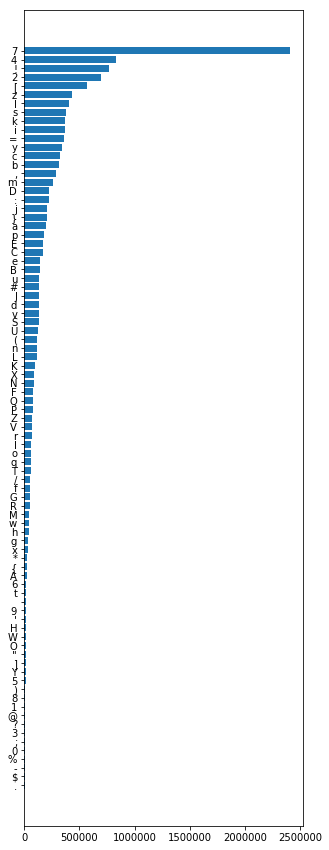

In [4]:
# Count occurences of characters of ciphertexts of difficulty 2
diff2_cntr = Counter(''.join(test[test['difficulty'] == 2]['ciphertext'].values))
# new dataframe with frequency and letter
diff2_stats = pd.DataFrame([[x[0], x[1]] for x in diff2_cntr.items()], columns=['Letter', 'Frequency'])
# sort dataframe on occurence of frequency
diff2_stats = diff2_stats.sort_values(by='Frequency', ascending=True)

# plot
f, ax = plt.subplots(figsize=(5, 15))
plt.barh(np.array(range(len(diff2_stats))) + 0.5, diff2_stats['Frequency'].values)
plt.yticks(np.array(range(len(diff2_stats))) + 0.5, diff2_stats['Letter'].values)
plt.show()

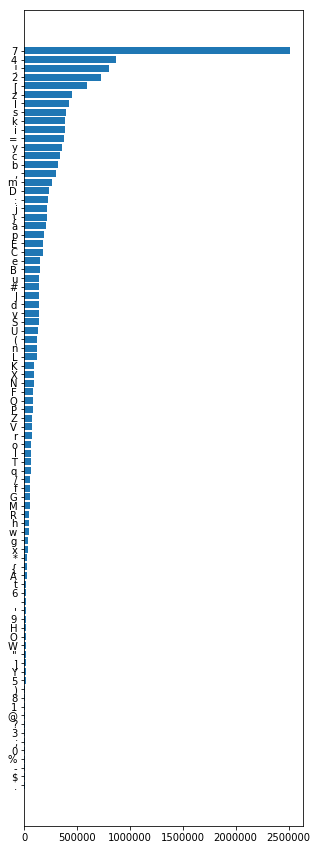

In [5]:
# Count occurences of characters of ciphertexts of difficulty 3
diff3_cntr = Counter(''.join(test[test['difficulty'] == 3]['ciphertext'].values))
# new dataframe with frequency and letter
diff3_stats = pd.DataFrame([[x[0], x[1]] for x in diff3_cntr.items()], columns=['Letter', 'Frequency'])
# sort dataframe on occurence of frequency
diff3_stats = diff3_stats.sort_values(by='Frequency', ascending=True)

# plot
f, ax = plt.subplots(figsize=(5, 15))
plt.barh(np.array(range(len(diff3_stats))) + 0.5, diff3_stats['Frequency'].values)
plt.yticks(np.array(range(len(diff3_stats))) + 0.5, diff3_stats['Letter'].values)
plt.show()

**While the ciphertexts for which we generated the barplots vary (the ciphertexts of difficulty 2 and difficulty 3 are not the same) we can clearly see that the distributions (almost) exactly match. This is a clear indication of a transposition cipher, where the letters of a text are just permuted.**

# More importantly, we can easily match cipher- and plaintexts now, since we know that the distributions of the text encrypted until level 2 must exactly match the ciphertext of difficulty 3 (with padding included)

In [6]:
# Let's get all plaintexts of length 700 (this can be done with any length % 100 == 0)
train_filtered = train[train['length'] == 700]
train_filtered['cipher2'] = train_filtered['text'].apply(lambda x: encrypt_step2(encrypt_step1(x)))

plain_to_cipher = defaultdict(list)
for i, row in tqdm_notebook(train_filtered.iterrows(), total=len(train_filtered)):
    row_cntr = Counter(row['cipher2'])
    test_filtered = test[(test['length'] == len(row['text'])) & (test['difficulty'] == 3)]
    for j, row2 in test_filtered.iterrows():
        row2_cntr = Counter(row2['ciphertext'])
        
        match = True
        for k in row_cntr:
            if k not in row2_cntr or row_cntr[k] != row2_cntr[k]:
                match = False
                break
                
        if match:
            plain_to_cipher[i].append(j)
            break
            
print(plain_to_cipher)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until



defaultdict(<class 'list'>, {5829: [12050], 6608: [12534], 8263: [30312], 11165: [10615], 12737: [19293], 16843: [36135], 17665: [31316], 17756: [1480], 27213: [44067], 27236: [20136], 27859: [38392], 29779: [15372], 35529: [27047], 36616: [7026], 40026: [41255], 40403: [40822]})


# Now, to find out to which position a certain letter is mapped, we search for letters that occur only once in the encrypted plaintext and see to which index it is mapped in the ciphertext

In [7]:
mapping = defaultdict(set)
for k in tqdm_notebook(plain_to_cipher):
    plain_encrypted = train_filtered.loc[k, 'cipher2']
    plain_cntr = Counter(plain_encrypted)
    
    cipher = test.loc[plain_to_cipher[k][0], 'ciphertext']
    cipher_cntr = Counter(cipher)
    
    for key in plain_cntr:
        if plain_cntr[key] == 1 and cipher_cntr[key] == 1:
            mapping[cipher.index(key)].add(plain_encrypted.index(key))
            
for key in sorted(mapping.keys()):
    print(key, mapping[key])


0 {0}
13 {286}
15 {330}
25 {550}
33 {21}
40 {89}
49 {197}
52 {221}
59 {307}
64 {353}
68 {397}
81 {549}
83 {571}
88 {617}
92 {661}
97 {24}
106 {130}
114 {218}
115 {222}
116 {240}
117 {244}
131 {398}
136 {460}
140 {504}
150 {614}
158 {3}
159 {19}
161 {41}
163 {63}
166 {91}
178 {223}
180 {245}
183 {283}
191 {371}
192 {377}
194 {399}
200 {465}
204 {509}
213 {613}
218 {663}
220 {685}
222 {18}
223 {26}
226 {62}
230 {106}
246 {282}
265 {488}
275 {598}
276 {612}
277 {620}
279 {642}
289 {61}
302 {203}
305 {237}
319 {391}
321 {413}
328 {489}
329 {501}
334 {555}
337 {589}
347 {699}
359 {126}
362 {160}
364 {182}
373 {280}
376 {314}
390 {468}
393 {500}
395 {522}
407 {654}
409 {676}
412 {7}
415 {37}
422 {117}
427 {169}
429 {191}
434 {249}
442 {337}
443 {345}
448 {403}
483 {80}
501 {278}
509 {366}
512 {404}
528 {580}
534 {646}
537 {674}
561 {233}
564 {273}
581 {453}
595 {607}
600 {669}
604 {10}
607 {34}
611 {78}
614 {120}
616 {142}
625 {232}
627 {254}
634 {340}
644 {450}
655 {562}
657 {584}
658 {604

# We find a pattern that is very related to the difficulty 4 challenge of previous competition, where we have to construct a transposition table that is used to permute the original text. 

- By looking at the first values, we see a periodicity of 22 occur (0 -> 22, 13 -> 286, 15 -> 330).
- This pattern stops after ceil(700 / 22) = 32 characters, e.g. 33 -> 21
- An interesting sequence: 
```
114 {218}
115 {222}
116 {240}
117 {244}
```
**--> We see that there is a difference of 22 between `116` & `114` and between `115` & `117`, which is exactly the number of columns/periodicity we noticed before!**

After looking at a lot of mappings for different lengths, we found the following pattern:

1) The first $ceil(\frac{L}{22})$, with $L$ the length of the input are mapped as follows: character on position $k$ is mapped to position $k * 22$

2) Then a transposition table is used for the following mappings, and we switch for the between column $1 + i$ and $22 - i$

In [8]:
def create_table(length, n_cols=22):
    n_rows = int(np.ceil(length / n_cols))
    table = np.zeros((n_rows, n_cols))
    table[:, 0] = list(range(n_rows))
    
    cntr = n_rows - 1
    for col in range(1, n_cols // 2):
        for row in range(n_rows):
            if 0 < (length % n_cols) <= col and row == n_rows - 1:
                table[row, col] = np.NaN
            else:
                cntr += 1
                table[row, col] = cntr
                
            
            if 0 < (length % n_cols) <= 22 - col and row == n_rows - 1:
                table[row, 22 - col] = np.NaN
            else:
                cntr += 1
                table[row, 22 - col] = cntr
            
    for row in range(n_rows):
        if 0 < (length % n_cols) <= n_cols // 2 and row == n_rows - 1:
            table[row, n_cols // 2] = np.NaN
        else:
            cntr += 1
            table[row, n_cols // 2] = cntr
        
    return table

np.set_printoptions(edgeitems=30, linewidth=100000, 
                    formatter=dict(float=lambda x: "% 4g" % x))
create_table(300)

# We now number the cells in this table from 0 -> L, starting from the left and top and going from left to right and from top to bottom.
# For length 300, the mapping thus becomes:
# * Map character k in 0 - 13 on 22 * k
# * Map character 14 on 1
# * Map character 15 on 21
# * Map character 16 on 23
# * Map character 17 on 43
# ...

array([[   0,   14,   41,   68,   95,  122,  149,  176,  203,  230,  258,  286,  259,  231,  204,  177,  150,  123,   96,   69,   42,   15],
       [   1,   16,   43,   70,   97,  124,  151,  178,  205,  232,  260,  287,  261,  233,  206,  179,  152,  125,   98,   71,   44,   17],
       [   2,   18,   45,   72,   99,  126,  153,  180,  207,  234,  262,  288,  263,  235,  208,  181,  154,  127,  100,   73,   46,   19],
       [   3,   20,   47,   74,  101,  128,  155,  182,  209,  236,  264,  289,  265,  237,  210,  183,  156,  129,  102,   75,   48,   21],
       [   4,   22,   49,   76,  103,  130,  157,  184,  211,  238,  266,  290,  267,  239,  212,  185,  158,  131,  104,   77,   50,   23],
       [   5,   24,   51,   78,  105,  132,  159,  186,  213,  240,  268,  291,  269,  241,  214,  187,  160,  133,  106,   79,   52,   25],
       [   6,   26,   53,   80,  107,  134,  161,  188,  215,  242,  270,  292,  271,  243,  216,  189,  162,  135,  108,   81,   54,   27],
       [   7,

In [9]:
def create_map(text, n_cols=22):
    table = create_table(len(text), n_cols=n_cols)
    mapping = {}
    rev_mapping = {}
    for i, c in enumerate(text):
        row_ix, col_ix = [x[0] for x in np.where(table == i)]
        new_pos = row_ix * n_cols + col_ix
        mapping[i] = new_pos
        rev_mapping[new_pos] = i

    return mapping, rev_mapping

def encrypt_step3(text):
    mapping, _ = create_map(text)
    output = ''
    for i, c in enumerate(text):
        output += text[mapping[i]]
    return output

def decrypt_step3(text):
    _, rev_mapping = create_map(text)
    output = ''
    for i, c in enumerate(text):
        output += text[rev_mapping[i]]
    return output

In [11]:
cipher = test[(test['difficulty'] == 3)].sample(1).iloc[0, :]['ciphertext']
step1 = decrypt_step3(cipher)
step2 = decrypt_step2(step1)
step3 = decrypt_step1(step2)
print(step3)

o4=:5@/tJep#This was just about the worst movie I've ever seen. All I could think about during the "early days" part of the film was how terrible some children must have it when they are born to mentally and emotionally unstable parents. I did think Sean played his role well, but the story sucked me into a pit of despair and made my stomach churn at stupidity of Mrs Xuinn. I noticed the accent mutilations as well. So true love is ditching your current husband and three young children for a guy you haven't seen ONCE in the last ten years? Sounds like those two should have shared that cell at the sanitarium.  Many of the character interactions didn't make sense, the story had ample amounts of LAME, and the funniest part was the very very end where we see the 'happy couple' and their two loser buddies DRINKING and DRIVING down the road in that stylish 1968 Buick Riviera. Classy.Em!p!G5upk!?
